In [2]:
# Alex Spence DSC 680 Project 1
# Hospital Readmission Prediction 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve

# Create folders
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete")

Setup complete


In [3]:
# load the raw dataset
df = pd.read_csv('diabetic_data.csv')

print(f"Raw data shape: {df.shape}")
df.head()

Raw data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Full cleaning 
# Replace ? with NaN
df = df.replace('?', np.nan)

# Drop high-missing or ID columns
df = df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty'], axis=1, errors='ignore')

# Create target early
df['readmitted_30'] = (df['readmitted'] == '<30').astype(int)
df = df.drop('readmitted', axis=1)

# Age to midpoint
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
           '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
df['age'] = df['age'].map(age_map)

# Medication change (use built-in 'change' column)
df['med_change'] = (df['change'] == 'Ch').astype(int)
df = df.drop('change', axis=1)

# Diabetes med
df['diabetesMed_yes'] = (df['diabetesMed'] == 'Yes').astype(int)
df = df.drop('diabetesMed', axis=1)

# Remove leakage (death/hospice/transfers)
leak = [11, 13, 14, 15, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(leak)]

# One-hot categorical
cat_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
            'admission_source_id', 'max_glu_serum', 'A1Cresult']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

# Simplify diagnosis codes
def simplify_diag(code):
    if pd.isna(code): return 'missing'
    code = str(code)
    if code.startswith('250'): return 'diabetes'
    if code.startswith(('E', 'V')): return 'external'
    try:
        n = float(code)
        if 390 <= n <= 459 or n == 785: return 'circulatory'
        if 460 <= n <= 519 or n == 786: return 'respiratory'
        if 520 <= n <= 579 or n == 787: return 'digestive'
        if 800 <= n <= 999: return 'injury'
        if 580 <= n <= 629 or n == 788: return 'genitourinary'
        return 'other'
    except:
        return 'other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col + '_cat'] = df[col].apply(simplify_diag)
df = pd.get_dummies(df, columns=[col for col in df.columns if col.endswith('_cat')], drop_first=True, dtype=int)
df = df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, errors='ignore')

# Final X/y – force numeric
y = df['readmitted_30']
X = df.drop('readmitted_30', axis=1)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float64')

print(f"Cleaning complete! Shape: {X.shape}, Readmission rate: {y.mean():.3%}")

Cleaning complete! Shape: (99280, 110), Readmission rate: 11.368%


In [5]:
# Train-test split and XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': (y_train == 0).sum() / y_train.sum()
}

model = xgb.train(params, dtrain, num_boost_round=400,
                  evals=[(dtest, 'test')], early_stopping_rounds=30, verbose_eval=False)

prob = model.predict(dtest)
print(f"XGBoost AUC: {roc_auc_score(y_test, prob):.3f}")

joblib.dump(model, 'models/final_xgboost_model.pkl')

XGBoost AUC: 0.661


['models/final_xgboost_model.pkl']

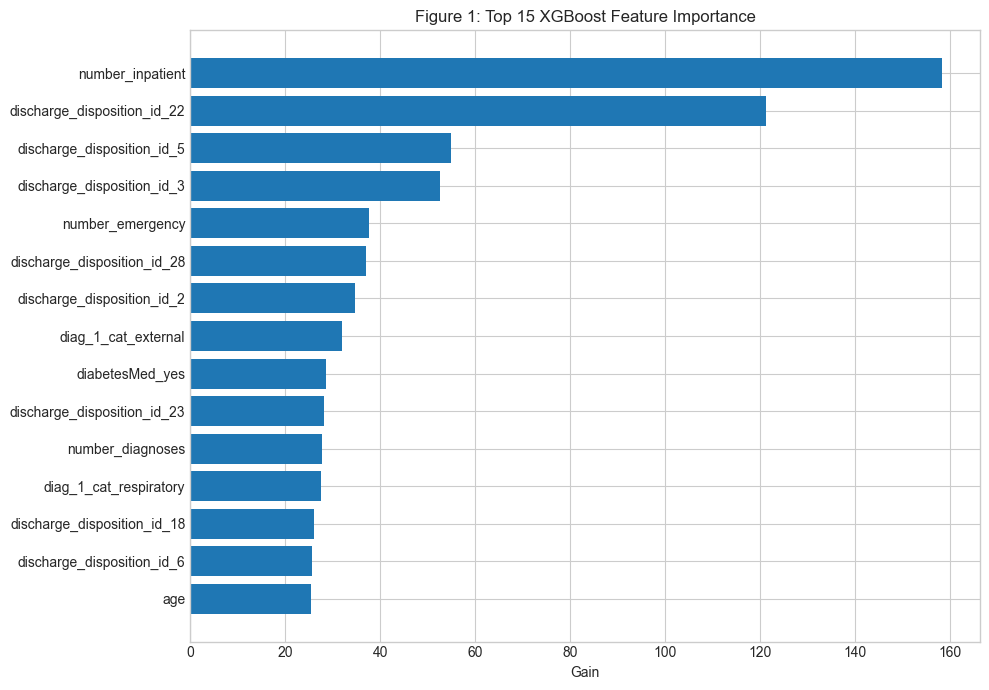

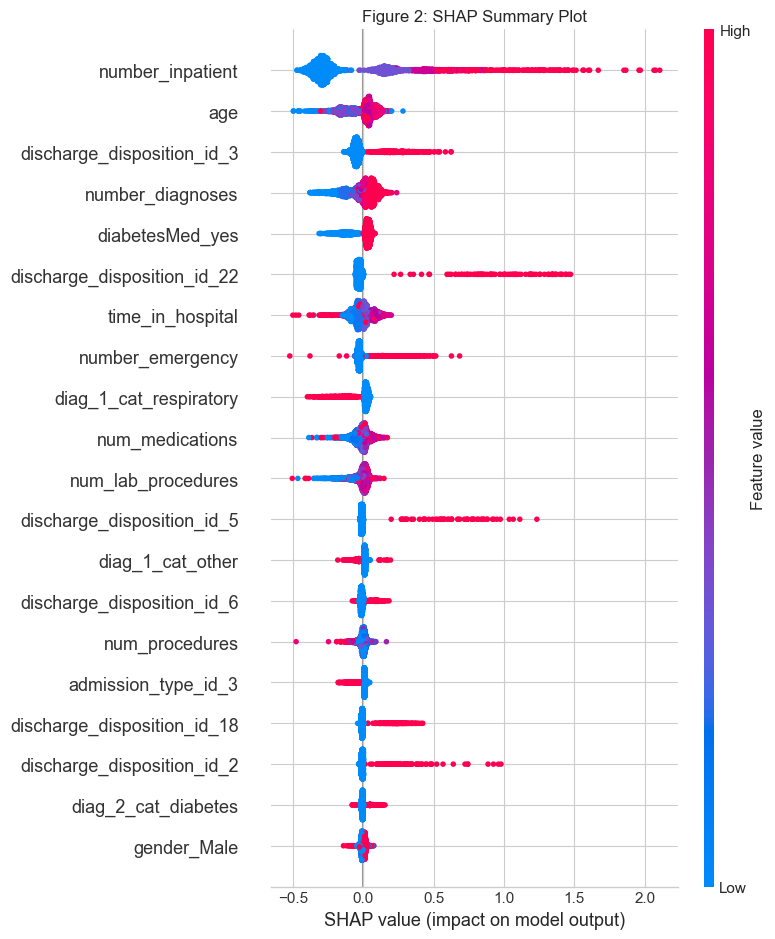

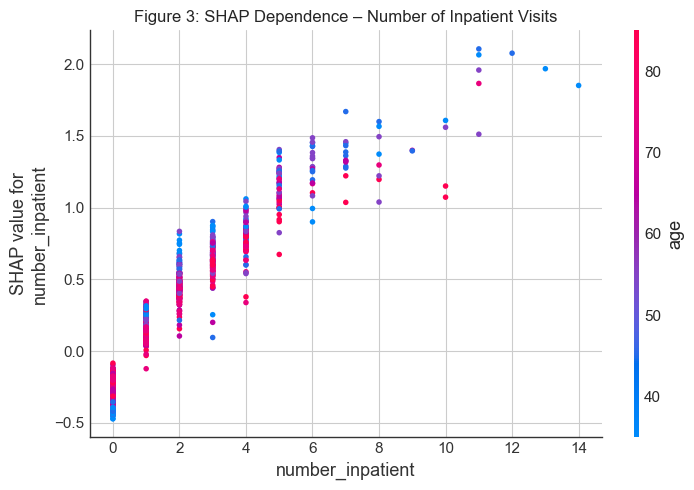

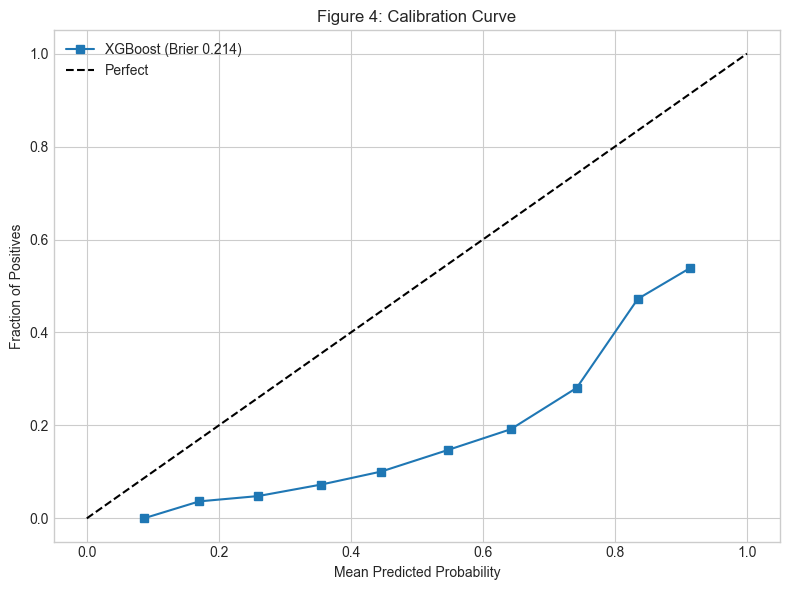

In [6]:
# Generate and save the 4 figures
# Figure 1: Feature Importance
imp = model.get_score(importance_type='gain')
top15 = sorted(imp.items(), key=lambda x: x[1], reverse=True)[:15]
feat, val = zip(*top15)

plt.figure(figsize=(10,7))
plt.barh(range(len(feat)), val)
plt.yticks(range(len(feat)), feat)
plt.gca().invert_yaxis()
plt.title('Figure 1: Top 15 XGBoost Feature Importance')
plt.xlabel('Gain')
plt.tight_layout()
plt.savefig('figures/fig1_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: SHAP Summary
explainer = shap.TreeExplainer(model)
sample = X_test.sample(4000, random_state=42)
shap_vals = explainer.shap_values(sample)

shap.summary_plot(shap_vals, sample, show=False)
plt.title('Figure 2: SHAP Summary Plot')
plt.tight_layout()
plt.savefig('figures/fig2_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: SHAP Dependence (number_inpatient – almost always top feature)
shap.dependence_plot('number_inpatient', shap_vals, sample, show=False)
plt.title('Figure 3: SHAP Dependence – Number of Inpatient Visits')
plt.tight_layout()
plt.savefig('figures/fig3_shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: Calibration Curve
pos, pred = calibration_curve(y_test, prob, n_bins=10)
plt.figure(figsize=(8,6))
plt.plot(pred, pos, "s-", label=f"XGBoost (Brier {brier_score_loss(y_test, prob):.3f})")
plt.plot([0,1],[0,1],"k--", label="Perfect")
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Figure 4: Calibration Curve')
plt.legend()
plt.tight_layout()
plt.savefig('figures/fig4_calibration.png', dpi=300, bbox_inches='tight')
plt.show()